In [709]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [710]:
#Let's read the data into python
com = pd.read_csv('Downloads/data_analyst/df_completed.csv')
order = pd.read_csv('Downloads/data_analyst/df_order.csv')
region = pd.read_csv('Downloads/data_analyst/df_region.csv')

In [711]:
#checking data quality
print(pd.isnull(order).sum()) # no null values
print(len(order))
print(order['order_request_id'].nunique()) 
# Every row represents a unqiue order - no duplicate orders in the order table

order_request_id          0
created_day_id            0
created_time              0
pickup_location_region    0
dtype: int64
35163
35163


In [712]:
#com table shows order request and completion time
print(pd.isnull(com).sum()) # no null values
print(len(com))
print(com['order_request_id'].nunique())
#It's good that there is no duplicate complete orders.

order_request_id    0
driver_id           0
completed_day_id    0
completed_time      0
dtype: int64
31887
31887


In [713]:
#Since there are duplicate orders, we can merge order and completion table together by order request id 
tx = order.merge(com, on = 'order_request_id', how = 'left')

In [714]:
#let's take a look at the data
tx.head(5)

,order_request_id,created_day_id,created_time,pickup_location_region,driver_id,completed_day_id,completed_time
0,0,1,00:12:11.793000,1,266.0,1.0,01:11:14.633000
1,1,1,00:17:19.546000,1,423.0,1.0,01:24:24.227000
2,2,1,00:18:50.404000,1,3070.0,1.0,01:13:31.654000
3,3,1,00:41:45.071000,4,4074.0,1.0,01:46:58.043000
4,4,1,00:50:47.141000,1,1868.0,1.0,02:04:15.526000


In [715]:
tx[['created_day_id', 'completed_day_id']].count()
#Not all orders get completed

created_day_id      35163
completed_day_id    31887
dtype: int64

In [716]:
#let's see how severe the overall incompletion is
len(tx[(pd.isnull(tx.completed_day_id))])/len(tx)
#~9.3% of orders are incompleted

0.09316611210647556

In [717]:
tx.describe()
#Created day id and completed day id represent the date. 
#These 2 columns make sense - created_day_id ranges from 1 - 28; completed day ranges from 1 - 30

,order_request_id,created_day_id,pickup_location_region,driver_id,completed_day_id
count,35163.000000,35163.000000,35163.000000,31887.000000,31887.000000
mean,17581.000000,15.506925,2.036800,2466.166024,15.513564
std,10150.828094,7.876393,1.027886,1435.622099,7.875601
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,8790.500000,9.000000,1.000000,1247.000000,9.000000
50%,17581.000000,16.000000,2.000000,2442.000000,16.000000
75%,26371.500000,23.000000,2.000000,3700.000000,23.000000
max,35162.000000,28.000000,5.000000,5024.000000,30.000000


In [718]:
tx[tx.created_day_id > tx.completed_day_id]
# There are 6 orders with an earlier order complete day than order create day. 

,order_request_id,created_day_id,created_time,pickup_location_region,driver_id,completed_day_id,completed_time
29128,29128,25,09:23:57.592000,1,2676.0,2.0,09:34:37.648000
30274,30274,25,19:03:37.999000,4,4980.0,1.0,19:59:33.327000
30320,30320,25,19:58:30.093000,2,1432.0,2.0,15:26:05.450000
32101,32101,27,09:24:31.462000,1,3429.0,2.0,16:50:05.579000
32928,32928,27,15:17:49.868000,2,4696.0,2.0,14:33:56.250000
33408,33408,27,18:13:18.742000,2,1.0,2.0,14:37:45.923000


In [719]:
# We can check with data engineering team to understand if there is a fundamental issue with our data in the pipeline. 
#Since it is just 6 rows, we are going to delete it. 
tx = tx[(tx.created_day_id <= tx.completed_day_id) | (pd.isnull(tx.completed_day_id))]

In [720]:
#Given that day_id is a Sunday, we can bucket the rest of day of week using day_id
def weekday_or_weekend(day):
    if (day == 1) or (day == 8) or (day == 15) or (day == 22):
        return 'Sun'
    elif (day == 2) or (day == 9) or (day == 16) or (day == 23):
        return 'Mon'
    elif (day == 3) or (day == 10) or (day == 17) or (day == 24):
        return 'Tue'
    elif (day == 4) or (day == 11) or (day == 18) or (day == 25):
        return 'Wed'
    elif (day == 5) or (day == 12) or (day == 19) or (day == 26):
        return 'Thurs'
    elif (day == 6) or (day == 13) or (day == 20) or (day == 27):
        return 'Fri'
    elif (day == 7) or (day == 14) or (day == 21) or (day == 28):
        return 'Sat'
    
tx['created_day'] = tx['created_day_id'].apply(weekday_or_weekend)
tx['created_day'] = pd.Categorical(tx['created_day'], ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']) #change to categorical with customized orders for easier reading

[Text(0, 0.5, 'Order Volume')]

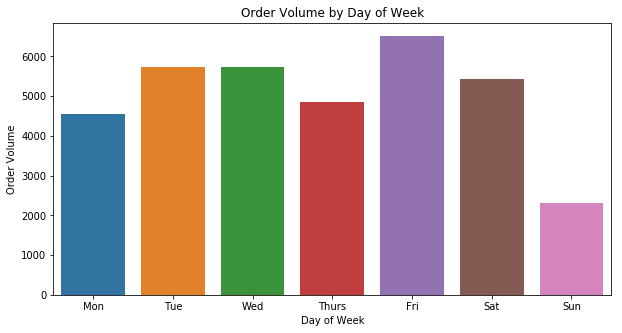

In [721]:
#create graph to show order volume by day of week
fig, ax = plt.subplots(1, 1, figsize = (10,5))

g = tx.groupby('created_day')['created_day_id'].count().reset_index()
sns.barplot(x = 'created_day', y = 'created_day_id', data = g, ax = ax)
ax.set_title('Order Volume by Day of Week')
ax.set(xlabel='Day of Week')
ax.set(ylabel='Order Volume')

#Order volume is the highest on Friday and the lowest on Sunday.

In [722]:
#extract hour from order placed time
tx['created_time (hour)'] = pd.to_datetime(tx['created_time']).apply(lambda x:x.hour)

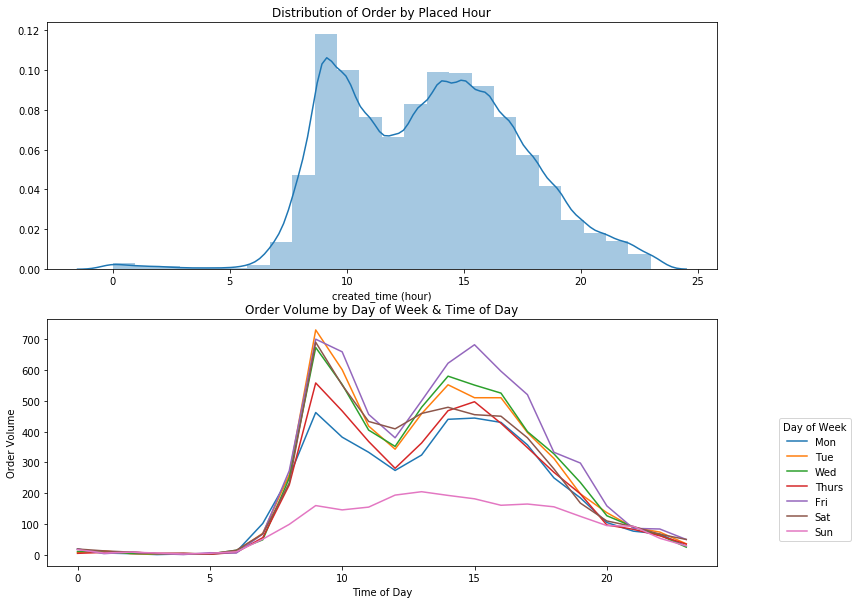

In [723]:
fig, ax = plt.subplots(2, 1, figsize = (12,10))

sns.distplot(tx['created_time (hour)'], ax= ax[0], bins= 24)
ax[0].set_title('Distribution of Order by Placed Hour')

tx.groupby(['created_time (hour)' ,'created_day'])['order_request_id'].count().unstack().plot(ax = ax[1])

ax[1].set_title('Order Volume by Day of Week & Time of Day')
ax[1].set(xlabel='Time of Day')
ax[1].set(ylabel='Order Volume')
ax[1].legend(title = 'Day of Week', loc = 5, borderaxespad=0.,  bbox_to_anchor=(1.0, 0.3, 0.2, 0.1))
# The order volume peaks at 9am and gradually slows down at noon. It gets busier and busier til 3pm. 
# The overall order volume follows fairly similar trend on almost every day of the week, except Sunday, when order volume is lower at all times.
# Drivers tend to take more order at noon on Saturdays than any other days.

In [724]:
#bucket to # of weeks using creater_day_id
def week(day):
    if (day >= 1 and day <= 7):
        return 1
    elif (day >= 8 and day <= 14):
        return 2
    elif (day >= 15 and day <= 21):
        return 3
    elif (day >= 22 and day <= 28):
        return 4

tx['created_week'] = tx['created_day_id'].apply(week)

[Text(0, 0.5, 'Order Volume')]

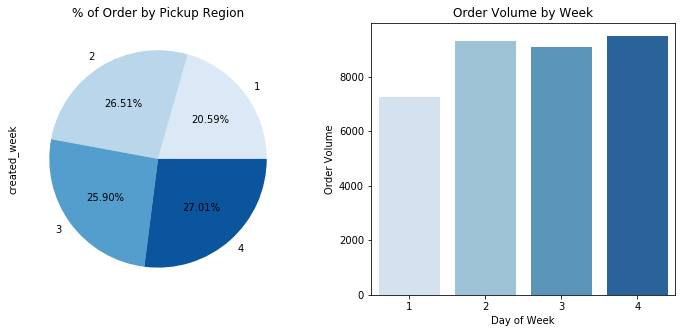

In [725]:
#create graph to show order volume by week
fig, ax = plt.subplots(1, 2, figsize = (12,5))

tx['created_week'].value_counts().sort_index().plot.pie(autopct='%1.2f%%', ax=ax[0], colors = ['#dbe9f6', '#bad6eb', '#539ecd',  '#0b559f'])
ax[0].set_title('% of Order by Pickup Region')

g = tx.groupby('created_week')['created_day_id'].count().reset_index()
sns.barplot(x = 'created_week', y = 'created_day_id', data = g, ax = ax[1], palette = 'Blues')
ax[1].set_title('Order Volume by Week')
ax[1].set(xlabel='Day of Week')
ax[1].set(ylabel='Order Volume')

#Orders are slightly lower in week 1 compare to week 2-4.

Text(0.5, 1.0, 'Order Volume by Location')

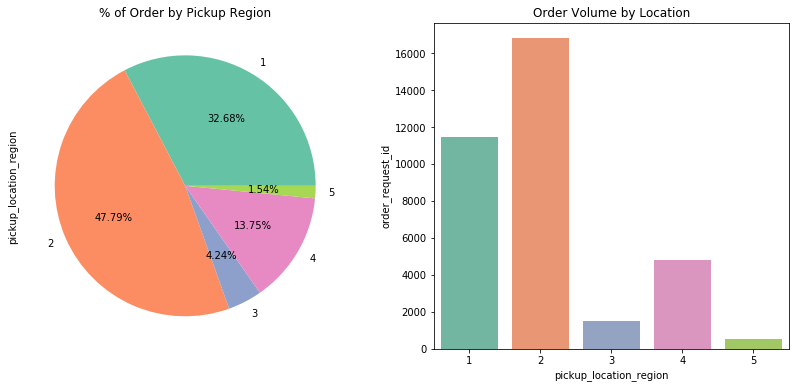

In [726]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

tx['pickup_location_region'].value_counts().sort_index().plot.pie(autopct='%1.2f%%', ax=ax[0], colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3'])
ax[0].set_title('% of Order by Pickup Region')

g = tx.groupby('pickup_location_region')['order_request_id'].count().reset_index()
sns.barplot(x = 'pickup_location_region', y = 'order_request_id', data = g, ax = ax[1], palette = 'Set2')
ax[1].set_title('Order Volume by Location')

#Orders for pickup at Location 1 and 2 make up of 80% of orders, followed by orders at location 4 (14%). Location 3 and 5 make up of only ~5% orders.

In [727]:
df = tx.groupby(['created_week'])[['driver_id', 'order_request_id']].count().reset_index()
df['complete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100

df

,created_week,driver_id,order_request_id,complete_rate
0,1,6589,7238,8.966565
1,2,8437,9319,9.464535
2,3,8234,9104,9.556239
3,4,8621,9496,9.214406


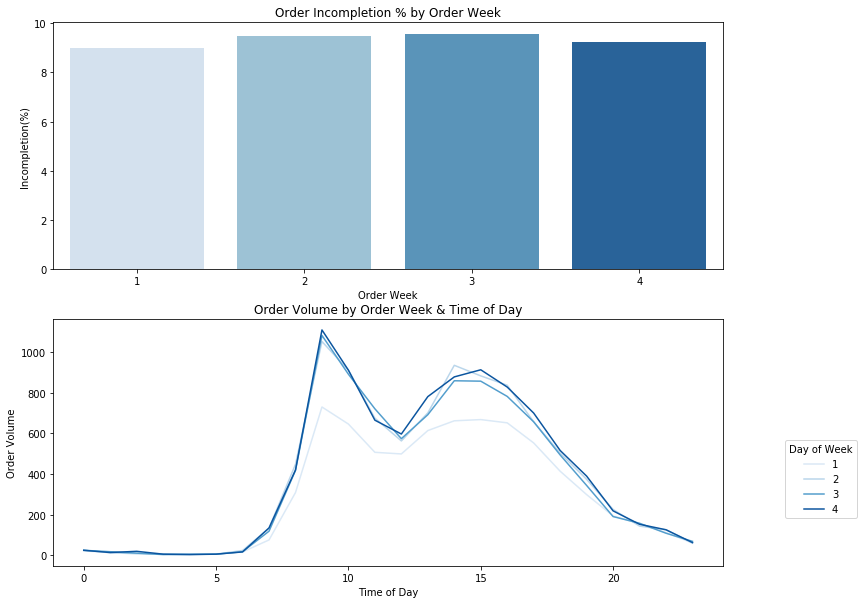

In [728]:
fig, ax = plt.subplots(2, 1, figsize = (12,10))

df = tx.groupby(['created_week'])[['driver_id', 'order_request_id']].count().reset_index()
df['complete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100
sns.barplot(x = 'created_week', y = 'complete_rate', data = df, ax = ax[0], palette = 'Blues')
ax[0].set_title('Order Incompletion % by Order Week')
ax[0].set(xlabel='Order Week')
ax[0].set(ylabel='Incompletion(%)')

#Order volumes for week 1 is slighly lower and incompletion rate is slightly lower too.
#Despite having the highest order volume in week 4, the incompletion rate for week 4 is the slightly higher than week 1's.

tx.groupby(['created_time (hour)' ,'created_week'])['order_request_id'].count().unstack().plot(ax = ax[1], colors = ['#dbe9f6', '#bad6eb', '#539ecd',  '#0b559f'])
ax[1].set_title('Order Volume by Order Week & Time of Day')
ax[1].set(xlabel='Time of Day')
ax[1].set(ylabel='Order Volume')
ax[1].legend(title = 'Day of Week', loc = 5, borderaxespad=0.,  bbox_to_anchor=(1.0, 0.3, 0.2, 0.1))

#Week 4's low incompletion rate is because GogoVan is able to maintain order volume at peak at 9am and attract more users to order at less busy hours like 1pm and 4pm after.

[Text(0, 0.5, 'Incompletion(%)')]

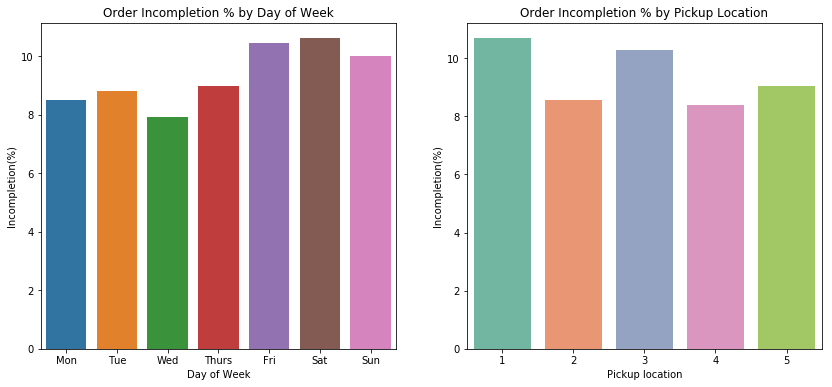

In [729]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

df = tx.groupby(['created_day'])[['driver_id', 'order_request_id']].count().reset_index()
df['incomplete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100

sns.barplot(x = 'created_day', y = 'incomplete_rate', data = df, ax = ax[0], order = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax[0].set_title('Order Incompletion % by Day of Week')
ax[0].set(xlabel='Day of Week')
ax[0].set(ylabel='Incompletion(%)')

#Friday through Sunday have slightly higher incomplettion rate than other days of the week.
#Given Sunday's volume are the lowest among all the days, let's look at orders placed on Friday and Saturday.

df = tx.groupby(['pickup_location_region'])[['driver_id', 'order_request_id']].count().reset_index()
df['incomplete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100

sns.barplot(x = 'pickup_location_region', y = 'incomplete_rate', data = df, ax = ax[1], palette = 'Set2')
ax[1].set_title('Order Incompletion % by Pickup Location')
ax[1].set(xlabel='Pickup location')
ax[1].set(ylabel='Incompletion(%)')

#Since huge portions of orders come from location 1 and 2. Let's focus on these two locations. 

# Incomplete order - location 1

Location 1 shows high order volume and also the high incompletion rate. 
Below are 6 graphs showing order incompletion rate for location 1 by placed hour for each day of the week (Mon - Sat).

Of all days of the week, Saturday has severe issue with incomplete orders.
On an hour level, 9-10am have severe order incompletion across all days, especially Tuesday, Friday and Saturday. We also see order being incompleted at 9pm everyday and 3-4pm on Saturday.
We don't have to worry about the high incompletion rate for orders placed at before 7am and at 11pm for now since it is skewed by low order volumes. 


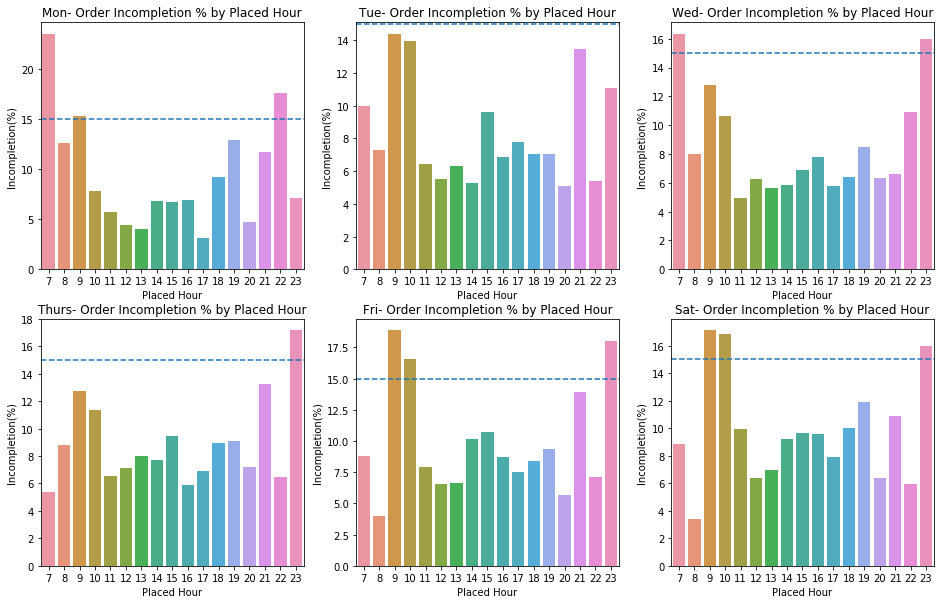

In [730]:
plt.figure(figsize = (16, 10))

for i, j in zip(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat'], np.arange(1, 7, 1)):
    df = tx[(tx['created_day'] == i) & (tx['created_time (hour)'] >= 7)].groupby(['created_time (hour)'])[['driver_id', 'order_request_id']].count().reset_index()
    df['complete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100
    ax = plt.subplot(2,3,j)
    sns.barplot(x = 'created_time (hour)', y = 'complete_rate', data = df, ax = ax )
    ax.axhline(15, ls='--')
    ax.set_title(i + '- Order Incompletion % by Placed Hour' )
    ax.set(xlabel='Placed Hour')
    ax.set(ylabel= 'Incompletion(%)')


# Incomplete order - location 2

Location 2 has the highest order volume but one of the lowest incompletion rate.
Each graph show order incompletion rate for location 2 by placed hour for each day of the week (Mon - Sat).
16% of orders placed are incompleted at 7am during early of the week. High incompletion rate at 9-10am and 3pm on Friday.
Similar to location 1, the high incompletion rate at 11pm is skewed by the low order volume.

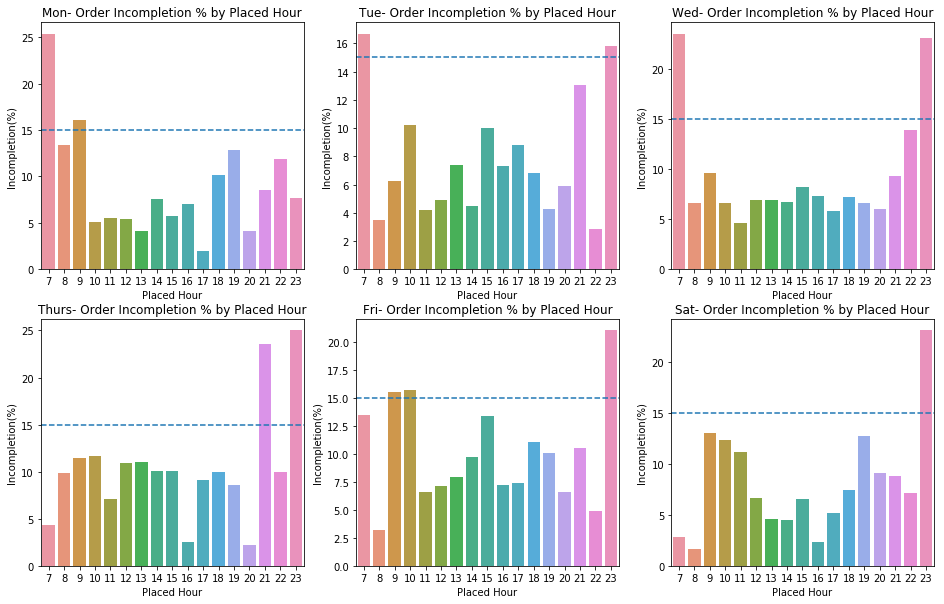

In [731]:
plt.figure(figsize = (16, 10))

for i, j in zip(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat'], np.arange(1, 7, 1)):
    df = tx[(tx['pickup_location_region'] == 2) & (tx['created_day'] == i) & (tx['created_time (hour)'] >= 7)].groupby(['created_time (hour)'])[['driver_id', 'order_request_id']].count().reset_index()
    df['complete_rate'] = (1 - df['driver_id']/df['order_request_id']) * 100
    ax = plt.subplot(2,3,j)
    sns.barplot(x = 'created_time (hour)', y = 'complete_rate', data = df, ax = ax )
    
    ax.axhline(15, ls='--')
    ax.set_title(i + '- Order Incompletion % by Placed Hour' )
    ax.set(xlabel='Placed Hour')
    ax.set(ylabel= 'Incompletion(%)')
    

In [732]:
# Only keep two decimals for seconds in created_time and completed_time column
tx['created_time'] = [i[:8] for i in tx['created_time']]
tx['completed_time'] = tx['completed_time'].astype(str)
tx['completed_time'] = [i[:8] for i in tx['completed_time']]

In [733]:
# convert to datetime type for created_time and completed_time column
tx['created_time'] = pd.to_datetime(tx['created_time'], errors='coerce')
tx['completed_time'] = pd.to_datetime(tx['completed_time'], errors='coerce')

In [734]:
# add day to the time
days_add = np.where(pd.isnull(tx['completed_day_id']), 0, tx['completed_day_id'] - tx['created_day_id']) 
tx['created_time_modified'] = [pd.to_datetime(i) - pd.DateOffset(days = j) for i , j in zip(tx['created_time'], days_add)]

In [735]:
# caclulate time it takes to deliver
tx['delivery_mins'] = (tx['completed_time'] - tx['created_time_modified'])/np.timedelta64(1,'m')

Majority of the orders are same-day deliveries.
In fact, across all days, more than 50% of the orders are delivered within the first hour of ordering.

In [736]:
tx.groupby('created_day')['delivery_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
created_day,,,,,,,,
Mon,4172.0,79.783221,200.459033,10.083333,37.716667,51.333333,68.966667,5325.633333
Tue,5236.0,82.355943,200.119854,8.166667,38.783333,52.225000,71.229167,6603.350000
Wed,5279.0,81.764807,276.379603,10.816667,37.441667,51.083333,69.350000,9692.216667
Thurs,4410.0,95.017521,362.717073,9.000000,38.016667,51.133333,70.316667,12096.900000
Fri,5834.0,94.836116,309.635659,9.750000,38.950000,52.758333,72.412500,10437.216667
Sat,4863.0,86.545545,247.518651,9.800000,37.900000,51.316667,69.733333,3729.283333
Sun,2087.0,84.078079,319.877855,12.133333,36.716667,49.983333,67.391667,8453.966667


A few orders on Wednesday and Thursday are either ordered > 5 days ahead or delivered late , driving up the delivery time.

In [737]:
# let's look at when users like to pre-order.
tx[(tx['completed_day_id'] - tx['created_day_id']) > 5][['order_request_id','created_day', 'pickup_location_region','delivery_mins']].sort_values('created_day')
# A few orders on Wednesday and Thursday are either ordered 5 days ahead or delivered late , driving up the delivery time.

,order_request_id,created_day,pickup_location_region,delivery_mins
3913,3913,Wed,4,7944.833333
20837,20837,Wed,4,9692.216667
21093,21093,Wed,2,8710.550000
4160,4160,Thurs,2,12096.900000
13458,13458,Thurs,1,11159.833333
24093,24093,Fri,2,10437.216667
545,545,Sun,1,8453.966667


In [738]:
tx.groupby(['pickup_location_region'])['delivery_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_location_region,,,,,,,,
1,10261.0,82.934433,259.732246,9.000000,36.866667,50.200000,67.950000,11159.833333
2,15363.0,84.689394,270.231184,8.166667,37.383333,50.466667,69.216667,12096.900000
3,1336.0,92.556487,266.790740,13.183333,36.741667,50.758333,68.637500,4351.266667
4,4428.0,99.312218,332.667409,11.116667,43.362500,56.991667,75.966667,9692.216667
5,493.0,99.122684,255.950805,15.816667,49.433333,64.150000,86.033333,4889.500000


Text(0.5, 1.0, 'Delivery time (in mins) by Pickup Location')

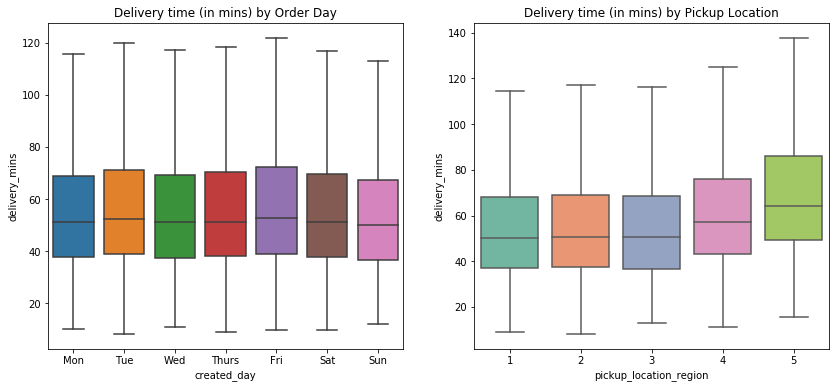

In [739]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

sns.boxplot(x = 'created_day', y = 'delivery_mins', data = tx, showfliers = False, ax = ax[0])
ax[0].set_title('Delivery time (in mins) by Order Day')
#Similar distribution of delivery time across days of week.

sns.boxplot(x = 'pickup_location_region', y = 'delivery_mins', data = tx, showfliers = False, ax = ax[1], palette = 'Set2')
ax[1].set_title('Delivery time (in mins) by Pickup Location')
#The sample size for orders from location 5 is much smaller than the rest of the location. 
#It can be easily skewed by a few data points with high delivery times. 
#However, we should keep monitoring the delivery time for location 5 to see if this is an ongoing trend. 
#Location 5 is a fairly uncommon pickup locations for drivers, hence drivers would need more experiences to be familiar with the route. 
#On GogoVan's side, it might be helpful for drivers by providing better instructions to locate the pickup spot. 
#The longer delivery time could also be because location 5 orders are the furthest from the drop off locations.
#In that case, we would need destination data to verify this. 

In [740]:
#calculate the incomplete order per week
df = tx.groupby('created_day')[['driver_id','order_request_id', 'completed_time']].nunique().reset_index()
df['incomplete_order'] = df['order_request_id'] - df['completed_time']
print('Average number of incomplete per week:{}'.format( df['incomplete_order'].sum()/4))

Average number of incomplete per week:1219.0


In [741]:
#calculate the stats for ride per driver
print(tx.groupby(['driver_id', 'created_week'])['completed_time'].count().reset_index()['completed_time'].describe())
#calculate the weekly number of unqiue driver 
print('Weekly # of unique driver:{}'.format(tx.groupby(['created_week'])['driver_id'].nunique().sum()/4))

print('\n')
print('Assuming that 40% of drivers who drive 2-3 rides get motivated to drive 2 more rides weekly, we would get')

print('weekly # of unique driver * % of total unique drivers * % of drivers incentivize X Additional hours for bonus = 3136.75 * 0.25 * 0.4 * 2 = {}'.format(3136.75 * 0.25 * 0.4 * 2 ))

print('\n')
print('Assuming that 80% of drivers who drive 3 rides get motivated to drive 1 more ride weekly, we would get')

print('weekly # of unique driver * % of total unique drivers * % of drivers incentivize X Additional hours for bonus = 3136.75 * 0.12 * 0.8 * 1 = {}'.format(3136.75 * 0.12 * 0.8 * 1 ))

print('\n')
print('Spent$:{}'.format(round(3136.75 * 0.25 * 0.4 + 3136.75 * 0.12 * 0.8 + 3136.75 * 0.13) * 50,2))

#The median rides given per driver is 2, meaning 50% of drivers give 2 rides per week. 
#This signifies huge potential from the supply side. 
#We know that there is 3136 unique drivers weekly and the 75th percentile of weekly rides is 3 rides per unqiue driver.

#If we give monetary incentives of $50 for drivers fulfilling 4 rides per week, 
#and assuming that 40% of the drivers who drive 2 -3 rides will be motivated, we would get an additional 627 rides. 

#Drivers who drive 3 rides weekly will even be more likely to fulfil an additional one ride, we would get an additional 300 rides. (3136.75 * 0.12 * 0.8 * 1 ). In total, we get 927 rides more than before. Under this incentives, we would be spending $51130 more to lower overall incompletion rate, and increase customer satisfaction and reduce churn in the long term. 

count    12547.000000
mean         2.540926
std          2.247299
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         34.000000
Name: completed_time, dtype: float64
Weekly # of unique driver:3136.75


Assuming that 40% of drivers who drive 2-3 rides get motivated to drive 2 more rides weekly, we would get
weekly # of unique driver * % of total unique drivers * % of drivers incentivize X Additional hours for bonus = 3136.75 * 0.25 * 0.4 * 2 = 627.35


Assuming that 80% of drivers who drive 3 rides get motivated to drive 1 more ride weekly, we would get
weekly # of unique driver * % of total unique drivers * % of drivers incentivize X Additional hours for bonus = 3136.75 * 0.12 * 0.8 * 1 = 301.128


Spent$:51150


# Recommendations

Here are a few recommendations on alleviating the supply and demand problem:

1) Surge pricing on location 1 and 2 at peak hours

For Location 1, 9-10am have severe order incompletion across all days, especially Tuesday, Friday and Saturday. We also see order being incompleted at 9pm everyday and 3-4pm on Saturday. For location 2, there is mild incompletion at 7am during early of the week and high incompletion rate at 9-10am and 3pm on Friday. We can apply surge pricing for location 1 orders at 9-10 am everyday but more on Tuesday, Friday and Saturday and 3-4pm on Saturday; for location 2 at 7am Monday, Tuesday and Wednesday and 9-10am and 3pm on Friday.

Surge pricing helps to prioritize orders by applying price multiples to the original price during peak hours. Customers who value the delivery higher will place orders, despite higher price, while those who don't value the delivery as much will place the order at non-peak hours to save some cost. 

2) Offer promotion on week 1 order if what we see is an ongoing trend

Based on this month's data, Week 1 has much lower order volumes than other weeks and also lower incompletion rate in general. We would like to look at more data to see this is a one-time event or an ongoing trend.
Let's check with marketing to see if there is any recent campaigns that cause more users to order after the first week. An example could be Gogovan started placing Facebook ads after the first week of this month. If this is an ongoing trend that signals on users' behavior, we can provide discounts to incentivize less time sensitive users to order on week 1.

3) Analyze order drop-off location data, driver data and transport goods data to understand time it takes for delivery

Location 5 has a longer median delivery time than any other locations. Since location 5 is a relatively big location and it is also a fairly uncommon pickup uncommon pickup locations for drivers, it could be that drivers need time to be familiar with the route in location 5.

We could potentially allocate location 5 pickup to more experience drivers and also provide better in-app support for locating the pickup spot. In this case, we would need driver data, such as, vehicle type, years of drivng experiences, to understand their experiences on driving. 

The longer median delivery time could also be explained by other factors including a longer delivery distance and delivery reason. Perhaps the drivers need to deliver from one end of location 5 to another end of location 4. Also, users might be asked to deliver furnitures and it takes time to load and offload the goods.
In this case, we would need destination location data and delivery type data to understand the true cause of longer delivery time for location 5 and even location 4.

4) Offer incentives on the supply side to fulfill demand 

Overall, we are seeing a lack of drivers to fulfill orders when needed. Surge pricing will alleviate most of the supply and demand imbalance. However, too much surge pricing could cause users to churn and go for our competitor, such as Lalamove. Ultimately, we need to develop strategy to incentivize drivers to do more deliveries. 

We know that the median rides given per driver is 2, meaning 50% of drivers give 2 rides per week. This signifies huge potential from the supply side. There is 3136 unique drivers weekly and the 75th percentile of weekly rides is 3 rides per unqiue driver.If we give monetary incentives of $50 for drivers fulfilling 4 rides per week, and assuming that 40% of the drivers who drive 2 -3 rides will be motivated, we would get an additional 627 rides. (3136.75 * 0.25 * 0.4 * 2 )

Drivers who drive 3 rides weekly will even be more likely to fulfil an additional one ride, we would get an additional 300 rides. (3136.75 * 0.12 * 0.8 * 1 ). In total, we get 927 rides more than before. Under this incentives, we would be spending $51130 more to lower overall incompletion rate, and increase customer satisfaction and reduce churn in the long term. This could be apply to a small subset of drivers to test the effect before rolling it out to more drivers. However, the downside of that is if drivers find out than other drivers get paid more for the same work, they would not be happy. 

Follow up:

1) There are some orders with created date later than the completed date. I deleted the data for this exercise but I would check with data engineering team to understand the data regarding this issue.


Appendix:

In [742]:
df = tx.groupby('created_day')[['driver_id','order_request_id', 'completed_time']].nunique().reset_index()
df['avg_order_per_unqiue_driver'] = df['order_request_id']/df['driver_id'] #average order per unique driver , including complete and incomplete orders
df['avg_com_order_per_unqiue_driver'] = df['completed_time']/df['driver_id'] #average completed order per unique driver  
df['incomplete_order_per_unqiue_driver'] = df['avg_order_per_unqiue_driver'] - df['avg_com_order_per_unqiue_driver'] # avg incomplete order per orders
df

,created_day,driver_id,order_request_id,completed_time,avg_order_per_unqiue_driver,avg_com_order_per_unqiue_driver,incomplete_order_per_unqiue_driver
0,Mon,2222,4560,4003,2.052205,1.801530,0.250675
1,Tue,2582,5742,4929,2.223857,1.908985,0.314872
2,Wed,2569,5734,5000,2.231997,1.946283,0.285714
3,Thurs,2353,4845,4213,2.059074,1.790480,0.268593
4,Fri,2782,6516,5475,2.342200,1.968009,0.374191
5,Sat,2431,5441,4621,2.238174,1.900864,0.337310
6,Sun,1213,2319,2040,1.911789,1.681781,0.230008


[Text(0, 0.5, 'Avg Order Per Unique Driver')]

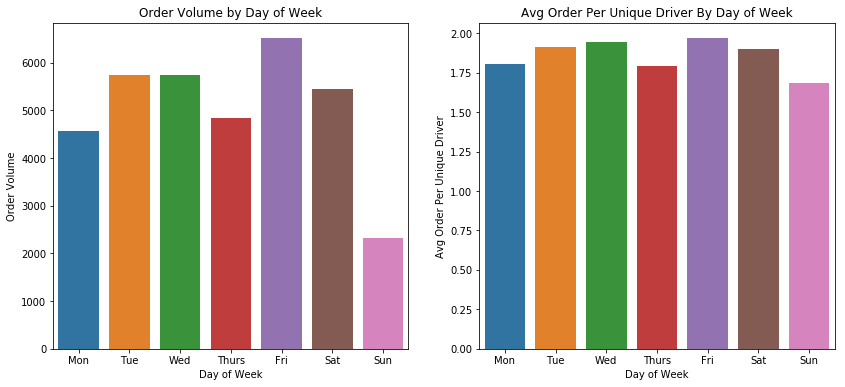

In [743]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

g = tx.groupby('created_day')['created_day_id'].count().reset_index()
sns.barplot(x = 'created_day', y = 'created_day_id', data = g, ax = ax[0])
ax[0].set_title('Order Volume by Day of Week')
ax[0].set(xlabel='Day of Week')
ax[0].set(ylabel='Order Volume')

df = tx.groupby('created_day')[['driver_id','order_request_id', 'completed_time']].nunique().reset_index()
df['avg_order_per_unqiue_driver'] = df['order_request_id']/df['driver_id'] #average order per unique driver , including complete and incomplete orders
df['avg_com_order_per_unqiue_driver'] = df['completed_time']/df['driver_id'] #average completed order per unique driver  
df['incomplete_order_per_unqiue_driver'] = df['avg_order_per_unqiue_driver'] - df['avg_com_order_per_unqiue_driver'] # avg incomplete order per orders

sns.barplot(x = 'created_day', y = 'avg_com_order_per_unqiue_driver', data = df, ax = ax[1], order = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax[1].set_title('Avg Order Per Unique Driver By Day of Week')
ax[1].set(xlabel='Day of Week')
ax[1].set(ylabel='Avg Order Per Unique Driver')

#Left graph shows order volume by day of week; 
#Right graph shows incomplete order per unique driver by day of week, which is defined as (Total Order - Total Completed Order)/Unique Drivers.
#Despite having lower volume than Tuesday and Wednesday, Friday has higher incomplete order per unique driver.
# This suggests that 

#Saturday has more unique drivers; Drivers complete more rides